# Polynomial fitting to bond curves

Fit a $n$th order polynomial to the $m$ lowest energies to interpolate a minimum energy and equilbrium bond lengths

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [7, 5]
plt.rcParams['font.size'] = 12

from apdft_tools.utils import *
from apdft_tools.utils import _remove_dimer_outliers, _dimer_poly_pred
from apdft_tools.data import prepare_dfs
from apdft_tools.prediction import *

json_path = '../../json-data/dimer-pyscf.apdft-data.posthf.json'
df_qc, df_apdft = prepare_dfs(json_path, get_CBS=False)

## Bond curve with QC data

In [2]:
system_label = 'b.h'
charge = 0
excitation_level = 0

basis_set = 'cc-pV5Z'
specific_atom = 0

qm_color = '#577590'
fit_color = "#F94144"

(-25.295981603437777, -24.70308549820349)

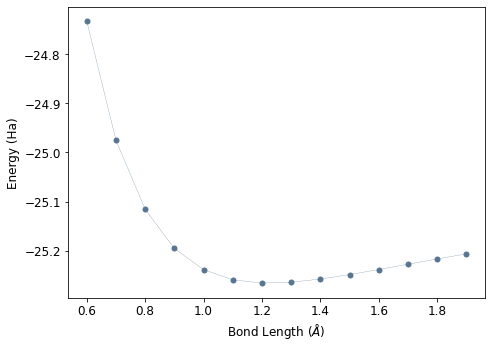

In [3]:
# Reference QC data
df_qc_system = df_qc.query(
    'system == @system_label'
    '& charge == @charge'
    '& lambda_value == 0'
)
sys_multiplicity = get_multiplicity(df_qc_system, excitation_level)
df_qc_system = df_qc_system.query('multiplicity == @sys_multiplicity')
target_n_electrons = df_qc_system.iloc[0]['n_electrons']
target_atomic_numbers = df_qc_system.iloc[0]['atomic_numbers']


qc_system_bl, qc_system_e = get_dimer_curve(df_qc_system, lambda_value=0)

###   FIGURE   ###
# Plots the QC bond length curve.

fig, ax = plt.subplots(1, 1, tight_layout=True)
fig.patch.set_facecolor('white')

ax.plot(
    qc_system_bl, qc_system_e,
    marker='o', markersize=5,
    linewidth=0.25, color=qm_color
)

ax.set_xlabel('Bond Length ($\AA$)')

ylim_buffer = 0.03
ax.set_ylabel('Energy (Ha)')
ax.set_ylim((min(qc_system_e)-ylim_buffer, max(qc_system_e)+ylim_buffer))

## Polynomial fit to minimum


Equilibrium bond length: 1.222 Ang.


Text(0, 0.5, 'Energy (eV)')

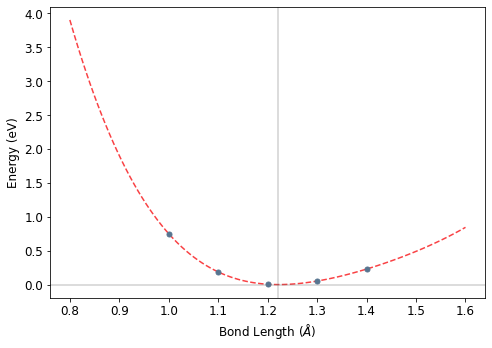

In [4]:
n_points = 2
poly_order = 4
remove_outliers = True
zscore_cutoff = 3.0

poly_bl_buffer = 0.2

idx_sort = np.argsort(qc_system_bl)
bond_lengths_qc = qc_system_bl[idx_sort]
e_qc = qc_system_e[idx_sort]

if remove_outliers:
    bond_lengths_qc, e_qc = _remove_dimer_outliers(
        bond_lengths_qc, e_qc
    )

e_min_idx = np.argmin(e_qc)
slice_start = e_min_idx - n_points
slice_end = e_min_idx + 1 + n_points
bond_lengths_for_fit = bond_lengths_qc[slice_start:slice_end]
e_for_fit = e_qc[slice_start:slice_end]

poly_coeffs = np.polyfit(bond_lengths_for_fit, e_for_fit, poly_order)
poly_bond_lengths = np.linspace(
    bond_lengths_for_fit[0]-poly_bl_buffer, bond_lengths_for_fit[-1]+poly_bl_buffer, num=100
)

poly_predictions = np.zeros(poly_bond_lengths.shape)
for i in range(len(poly_predictions)):
    poly_predictions[i] = _dimer_poly_pred(poly_bond_lengths[i], poly_coeffs)
    
bond_length_eq, e_eq = find_poly_min(bond_lengths_for_fit, poly_coeffs)

print(f'Equilibrium bond length: {bond_length_eq:.3f} Ang.')

###   FIGURE   ###
fig, ax = plt.subplots(1, 1, tight_layout=True)
fig.patch.set_facecolor('white')

ax.plot(
    bond_lengths_for_fit, hartree_to_ev(e_for_fit - e_eq),
    marker='o', markersize=5,
    linestyle='', color=qm_color
)
ax.plot(
    poly_bond_lengths, hartree_to_ev(poly_predictions - e_eq),
    marker='',
    linestyle='--', zorder=0, color=fit_color
)

ax.axhline(0, 0, 2, color='dimgrey', alpha=0.3, linestyle='-', zorder=0)
ax.axvline(bond_length_eq, 0, 20, color='dimgrey', alpha=0.3, linestyle='-', zorder=0)

ax.set_xlabel('Bond Length ($\AA$)')

ax.set_ylabel('Energy (eV)')


## Equilibrium predictions



In [5]:
system_label = 'o.h'
system_charge = 0
excitation_level = 0
use_fin_diff = True
considered_lambdas = None

basis_set = 'cc-pV5Z'
specific_atom = 0
calc_type = 'alchemy'
n_points = 2
poly_order = 4

bl_eq_qc, e_eq_qc = dimer_eq(
    df_qc, system_label, system_charge, excitation_level=excitation_level, calc_type='qc',
    use_fin_diff=use_fin_diff, df_apdft=df_apdft, specific_atom=0,
    direction=None, basis_set=basis_set, n_points=n_points, poly_order=poly_order,
    remove_outliers=False, zscore_cutoff=3.0, considered_lambdas=considered_lambdas
)

bl_eq_pred, e_eq_pred = dimer_eq(
    df_qc, system_label, system_charge, excitation_level=excitation_level, calc_type=calc_type,
    use_fin_diff=use_fin_diff, df_apdft=df_apdft, specific_atom=0,
    direction=None, basis_set=basis_set, n_points=n_points, poly_order=poly_order,
    remove_outliers=False, zscore_cutoff=3.0, considered_lambdas=considered_lambdas
)

print(f'PySCF prediction of {system_label} (chrg {system_charge}) eq. bond length: {bl_eq_qc[system_label][0]:.3f} A\n')
if use_fin_diff:
    print(f'APDFT predictions:')
    print(pd.DataFrame(bl_eq_pred, index=[f'APDFT{n}' for n in range(5)]))
else:
    print(f'Alchemical predictions:')
    print(pd.DataFrame(bl_eq_pred, index=[f'APDFT']))

PySCF prediction of o.h (chrg 0) eq. bond length: 0.968 A

APDFT predictions:
            ne.h       f.h       n.h
APDFT0  1.900000  0.998310  1.037806
APDFT1  0.788050  0.908013  0.952701
APDFT2  0.932870  0.979168  0.957903
APDFT3  1.151029  0.971671  1.400000
APDFT4  1.100000  0.965359  1.238196


/home/alex/.local/lib/python3.8/site-packages/apdft_tools/prediction.py:609: RankWarning: Polyfit may be poorly conditioned
  bond_lengths_fit, poly_coeffs = fit_dimer_poly(
